(4500258,)
22050
204.09333333333333


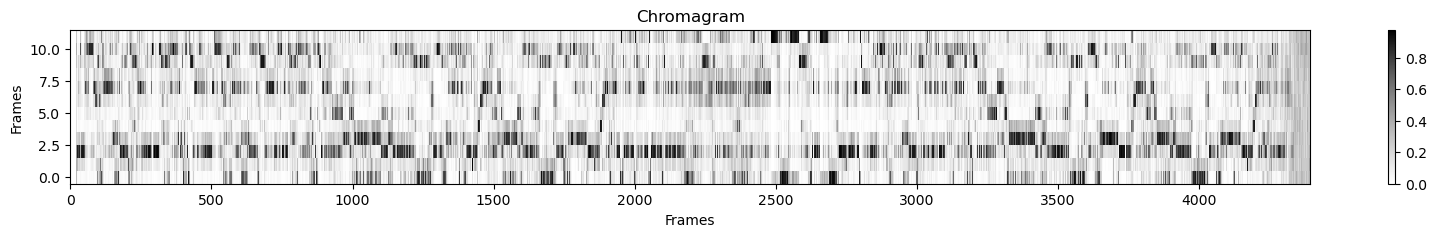

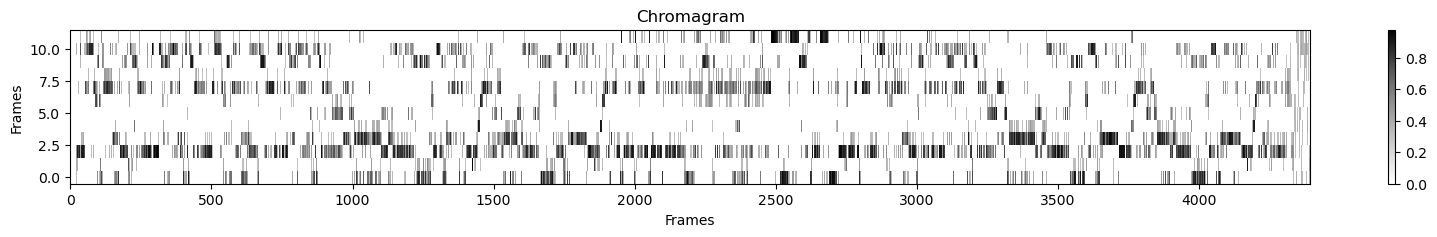

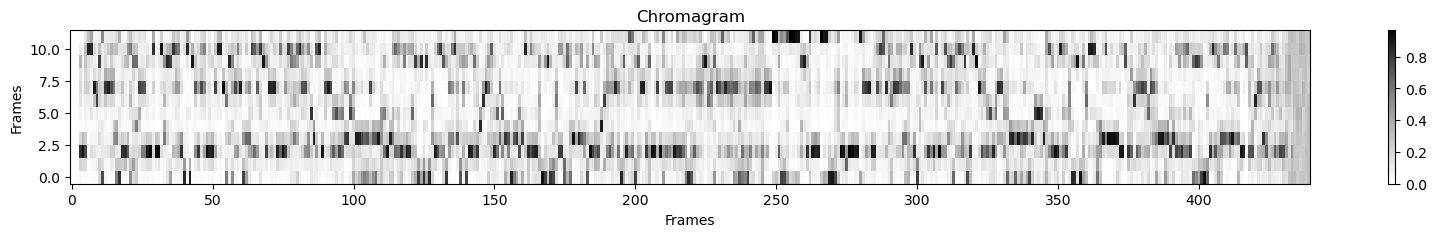

2.1533203125
(12, 440)


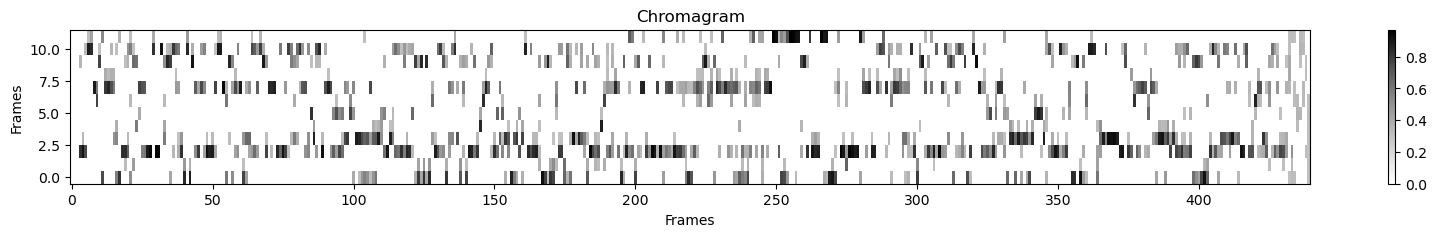

In [1]:
import numpy as np
import os, sys, librosa, tqdm
from scipy import signal
from scipy.interpolate import interp1d
from matplotlib import pyplot as plt
import matplotlib
import matplotlib.gridspec as gridspec
import IPython.display as ipd
import pandas as pd
import cv2
import lib.util as u
import soundfile as sf

sys.path.append('..')
import libfmp.b
import libfmp.c2
import libfmp.c3
import libfmp.c4
import libfmp.c6

#%matplotlib inline

#audio_path = 'files/epic movie trailer.mp3'
audio_path = 'files/FMP_C4_Audio_Brahms_HungarianDances-05_Ormandy.wav'
#audio_path = 'files/BENNETT - Vois sur ton chemin (Techno Mix).mp3'
#audio_path = 'files/Scale_Chromatic_Piano.wav'
audio, Fs = librosa.load(audio_path)
audio_dur_seconds = audio.shape[0] / Fs

print(audio.shape)
print(Fs) 
print(audio_dur_seconds)



# Chromagram
N, H = 2048, 1024
#N, H = 2205, 4410
chromagram = librosa.feature.chroma_stft(y=audio, sr=Fs, tuning=0, norm=2, hop_length=H, n_fft=N)
u.plot_matrix(chromagram, figsize=(20,2), cmap_compression = -1, title='Chromagram')  

thresh = 0.3
chromagram_masked = chromagram.copy()
chromagram_masked_indices = chromagram < thresh
chromagram_masked[chromagram_masked_indices] = 0
u.plot_matrix(chromagram_masked, figsize=(20,2), cmap_compression = -1, title='Chromagram')

down_sampling = 10
chromagram_DS, Fs_X = libfmp.c3.smooth_downsample_feature_sequence(chromagram, Fs/H, filt_len=1, down_sampling=down_sampling)
u.plot_matrix(chromagram_DS, figsize=(20,2), cmap_compression = -1, title='Chromagram')
print(Fs_X)
print(chromagram_DS.shape)

thresh = 0.3
chromagram_masked = chromagram_DS.copy()
chromagram_masked_indices = chromagram_DS < thresh
chromagram_masked[chromagram_masked_indices] = 0
u.plot_matrix(chromagram_masked, figsize=(20,2), cmap_compression = -1, title='Chromagram')

In [11]:


fps_video = chromagram_DS.shape[1] / audio_dur_seconds * down_sampling
print(fps_video)
21.558763964199386 - 21.534265368785523


21.558763964199386


0.024498595413863455

#### __Compute SSM__

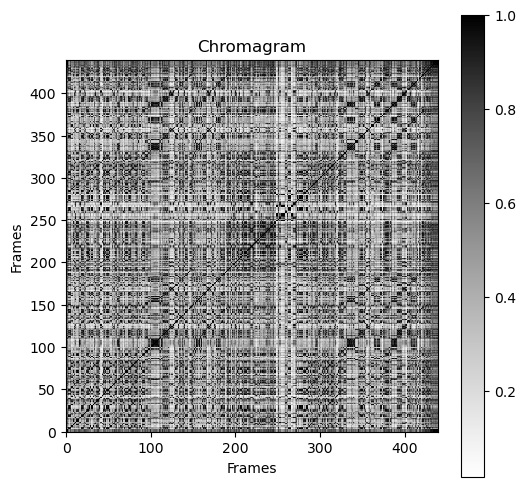

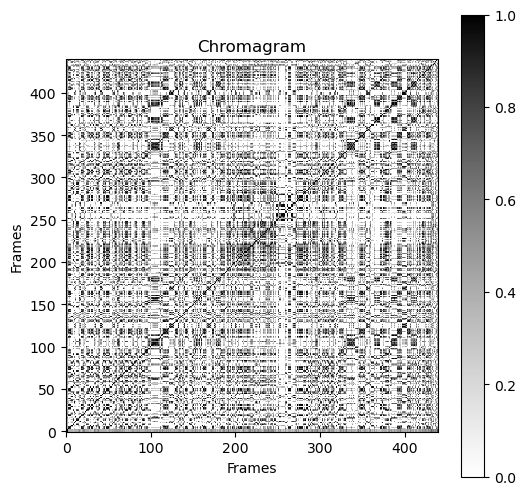

In [3]:
# SSM 
X1 = libfmp.c3.normalize_feature_sequence(chromagram_DS, norm='2', threshold=0.001)
S1 = u.compute_sm_dot(X1,X1)

u.plot_matrix(S1, figsize=(6,6), cmap_compression = -1, title='Chromagram')



X2 = libfmp.c3.normalize_feature_sequence(chromagram_masked, norm='2', threshold=0.001)
S2 = u.compute_sm_dot(X2,X2)

u.plot_matrix(S2, figsize=(6,6), cmap_compression = -1, title='Chromagram')


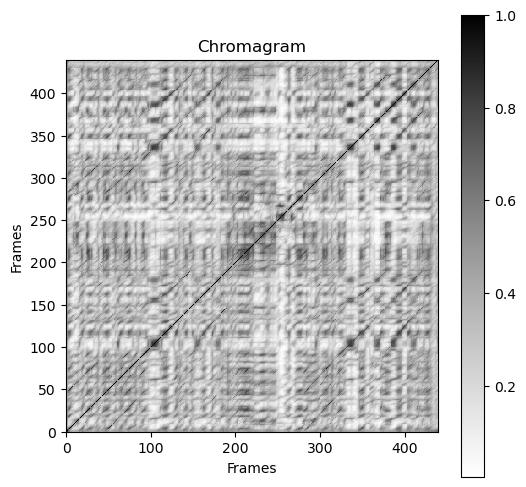

In [4]:
smoothed_SSM = librosa.segment.path_enhance(S2, 10, max_ratio=19.5)
u.plot_matrix(smoothed_SSM, figsize=(6,6), cmap_compression = -1, title='Chromagram')

#### __Compute Fitness__


#### __Bandpass Filter__

In [ ]:
# Load the audio file using librosa (replace 'your_song.mp3' with the actual filename)

data, Fs = librosa.load(audio_path, sr=None)

# Set the desired bandpass filter parameters
lowcut = 50  # Low cutoff frequency in Hz
highcut = 500  # High cutoff frequency in Hz
order = 4  # Filter order

# Apply the bandpass filter
filtered_data = u.butter_bandpass_filter(data, lowcut, highcut, Fs, order)

# Save the filtered audio using soundfile
sf.write('filtered_song.wav', filtered_data, Fs)

duration = (filtered_data.shape[0])/Fs

# Chroma Feature Sequence
N, H = 4096, 1024
chromagram = librosa.feature.chroma_stft(y=filtered_data, sr=Fs, tuning=0, norm=2, hop_length=H, n_fft=N)
X, Fs_X = libfmp.c3.smooth_downsample_feature_sequence(chromagram, Fs/H, filt_len=41, down_sampling=10)


# SSM 
X = libfmp.c3.normalize_feature_sequence(X, norm='2', threshold=0.001)
S = u.compute_sm_dot(X,X)
fig, ax = u.plot_feature_ssm(X, 1, S, 1, duration*Fs_X, clim_X=[0,1], clim=[0,1], label='Time (seconds)')

In [ ]:
# TODO SSM
# TODO Enchanced SSM
# TODO Fitness Measure
# TODO Scape Plot
# TODO Choose Top N segments with hhighest Fitness
# TODO Visualize Top N segments
# TODO Do the algorithm from the thesis
# TODO create frames 
# TODO create video from frames

#### __Frame Creation__

In [3]:
def create_frames(chromagram, audio_dur_seconds, fps_video, width, height):


    chromagram = (chromagram - chromagram.min()) / (chromagram.max() - chromagram.min())    # Normalize the values: [0, 1] range
    chromagram = (chromagram * 255).astype(np.uint8)    # Scale the values: [0, 255] int range
    chromagram = cv2.bitwise_not(chromagram)            # Invert the colors

    # Create a black canvas for the image
    h, w = chromagram.shape
    image = np.zeros((h, w, 3), dtype=np.uint8)
    image.fill(255)

    # Assign the chromagram values to the color channels
    for i in range(3):
        image[:, :, i] = chromagram

    image = np.flipud(image)    # Flip the image vertically
    

    # Resize while maintaining the aspect ratio
    image = cv2.resize(image, (chromagram.shape[1], height), interpolation=cv2.INTER_NEAREST_EXACT)
    print(image.shape)
    background = np.zeros((height, width, 3), dtype=np.uint8)

    number_frames = audio_dur_seconds*fps_video
    number_frames = int(np.rint(number_frames))

    
    frames = []
    half = width // 2

    start_img, end_img = 0, half
    start_frame, end_frame = half, width

    # for short audios
    if chromagram.shape[1] < half:
        end_img = chromagram.shape[1]
        end_frame = half + chromagram.shape[1]

    # here the frames are composed
    for i in tqdm(range(number_frames)):

        start_frame -= 1
        end_img += 1

        # once the image reaches the left side
        if start_frame == -1:
            start_frame = 0
            start_img += 1

        # once image starts getting exhausted on the right
        if end_img > chromagram.shape[1]:
            end_frame -= 1

        frame = background.copy()

        #print(f'frame: {start_frame} - {end_frame} | img: {start_img} - {end_img}')
        #print(f'frame shape: {frame[:,start_frame:end_frame,:].shape} | img shape: {image[:,start_img:end_img,:].shape}')

        frame[:,start_frame:end_frame,:] = image[:,start_img:end_img,:]
        frame[:,start_frame:half,0].fill(255)    #red fill

        frames.append(frame)
        #cv2.imwrite(f'experiment/frame{i}.png', frame)

    return frames


In [4]:
chromagram = chromagram_masked.copy()

fps_video = chromagram.shape[1] / audio_dur_seconds

# output dimensions of the video:
width = 1280
height = 200
# 720p = 1280x720 pixels

output_path = 'result2.mp4'

In [5]:

frames = create_frames(chromagram, audio_dur_seconds, fps_video, width, height)     

#u.create_video_cv2(frames, output_path, fps_video, width, height)
u.create_video_with_audio(frames, audio_path, output_path, fps_video)

(200, 2625, 3)


100%|██████████| 2625/2625 [00:00<00:00, 3840.16it/s]


Moviepy - Building video result2.mp4.
MoviePy - Writing audio in result2TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video result2.mp4



Moviepy - Done !
Moviepy - video ready result2.mp4
